In [2]:
import cupy 
import numpy 
import math 
import matplotlib.pyplot as plt

In [3]:
cupy.__version__

'13.4.1'

In [4]:
def prepare(height, width, numpy=numpy):     
    y, x = numpy.ogrid[-1 : 0 : height * 1j, -1.5 : 0 : width * 1j]     
    c = x + y * 1j     
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)     
    return c, fractal

def run(c, fractal, maxiterations=20):    
    fractal *= 0  # set fractal to maxiterations without replacing it     
    fractal += maxiterations     
    z = c     
    for i in range(maxiterations):         
        z **= 2         
        z += c         
        diverge = z.real ** 2 + z.imag ** 2 > 2 ** 2         
        z[diverge] = 2         
        diverge &= fractal == maxiterations         
        fractal[diverge] = i
    return fractal

Executing exactly the same code: first with Numpy on the CPU, then with CuPy on the GPU.

In [5]:
c, fractal = prepare(8000, 12000, numpy)

In [6]:
%%timeit 
_ = run(c, fractal)

15.7 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
c, fractal = prepare(8000, 12000, cupy)

In [8]:
%%timeit 
_ = run(c, fractal) 
cupy.cuda.Stream.null.synchronize()

1.94 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
cupy_single = cupy.ElementwiseKernel(     
    "complex128 cpx, int32 maxiterations",     
    "int32 res",     
    """     
    res = maxiterations;     
    complex<double> z = cpx;
    
    for (int i=0; i<maxiterations; i++) {         
        z = z*z + cpx;                  
        if(z.real()*z.real() + z.imag()*z.imag() > 4) {             
            res = i;             
            break;         
        }     
    }          
    """,     
    "fract_el", 
)

In [10]:
c, _ = prepare(8000, 12000, cupy)

Running the raw kernel using the single‐precision floating point arithmetic:

In [11]:
%%timeit 
fractal = cupy_single(c, 20) 
cupy.cuda.Stream.null.synchronize()

36.1 ms ± 9.52 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
cupy_kernel = cupy.RawKernel(     
""" 
extern "C"  
__global__ void fractal(double* c, int* fractal, int height, int width, int maxiterations) {     
    const int x = threadIdx.x + blockIdx.x*blockDim.x;     
    const int y = threadIdx.y + blockIdx.y*blockDim.y;     
    double creal = c[2 * (x + height*y)];     
    double cimag = c[2 * (x + height*y) + 1];     
    double zreal = creal;     
    double zimag = cimag;     
    fractal[x + height*y] = maxiterations;     
    for (int i = 0;  i < maxiterations;  i++) {         
        double zreal2 = zreal*zreal - zimag*zimag + creal;         
        double zimag2 = 2*zreal*zimag + cimag;         
        zreal = zreal2;         zimag = zimag2;         
        if (zreal*zreal + zimag*zimag > 4) {             
            fractal[x + height*y] = i;             
            break;         
        }     
    } 
} 
""",     
"fractal", 
)

In [13]:
def run_pycuda(height, width, maxiterations=20):     
  y, x = cupy.ogrid[-1 : 0 : height * 1j, -1.5 : 0 : width * 1j]     
  grid = (int(math.ceil(height / 32)), int(math.ceil(width / 32)))     
  c = x + y * 1j     
  fractal = cupy.empty(c.shape, dtype=cupy.int32) + maxiterations     
  cupy_kernel(         
      grid,         
      (32, 32, 1),         
      [             
          c.view(cupy.double),             
          fractal,             
          cupy.int32(height),             
          cupy.int32(width),             
          cupy.int32(maxiterations),         
      ],     
  )     
  return c, fractal

Running the raw kernel using the double‐precision floating point arithmetic:

In [14]:
%%timeit 
_, fractal = run_pycuda(8000, 12000) 
cupy.cuda.Stream.null.synchronize()

37.6 ms ± 8.79 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Output visualization with Matplotlib:

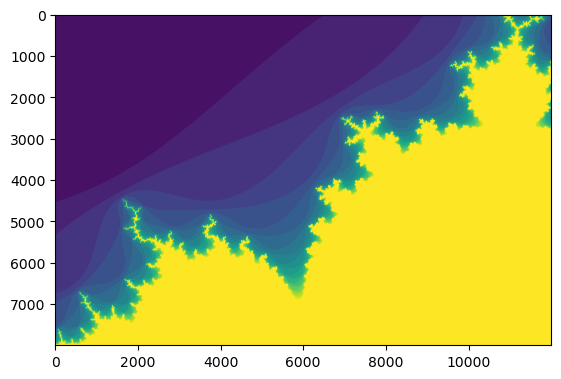

In [15]:
_, fractal = run_pycuda(8000, 12000) 
plt.imshow(fractal.get())